In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def load_cifar():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return (x_train, y_train), (x_test, y_test)
    
(x_train, y_train), (x_test, y_test) = load_cifar()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [2]:
from cifar.cifar_capsnet_efficient import EfficientCapsNet

BATCH_SIZE = 100
INPUT_SHAPE = (32, 32, 3)
N_CLASS = 10

# EfficientCapsNet(input_shape=INPUT_SHAPE,
#                  n_class=N_CLASS,)

model, eval_model, manipulate_model = EfficientCapsNet(input_shape=INPUT_SHAPE,
                                                       n_class=N_CLASS,)
model.summary()


starting EfficientCapsNet (32, 32, 3) 10
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 24, 24, 64), dtype=tf.float32, name=None), name='batch_normalization_2/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='batch_normalization_5/FusedBatchNormV3:0', description="created by layer 'batch_normalization_5'")
Model: "Efficinet_CapsNet_Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
_______________________________________________________________________________________

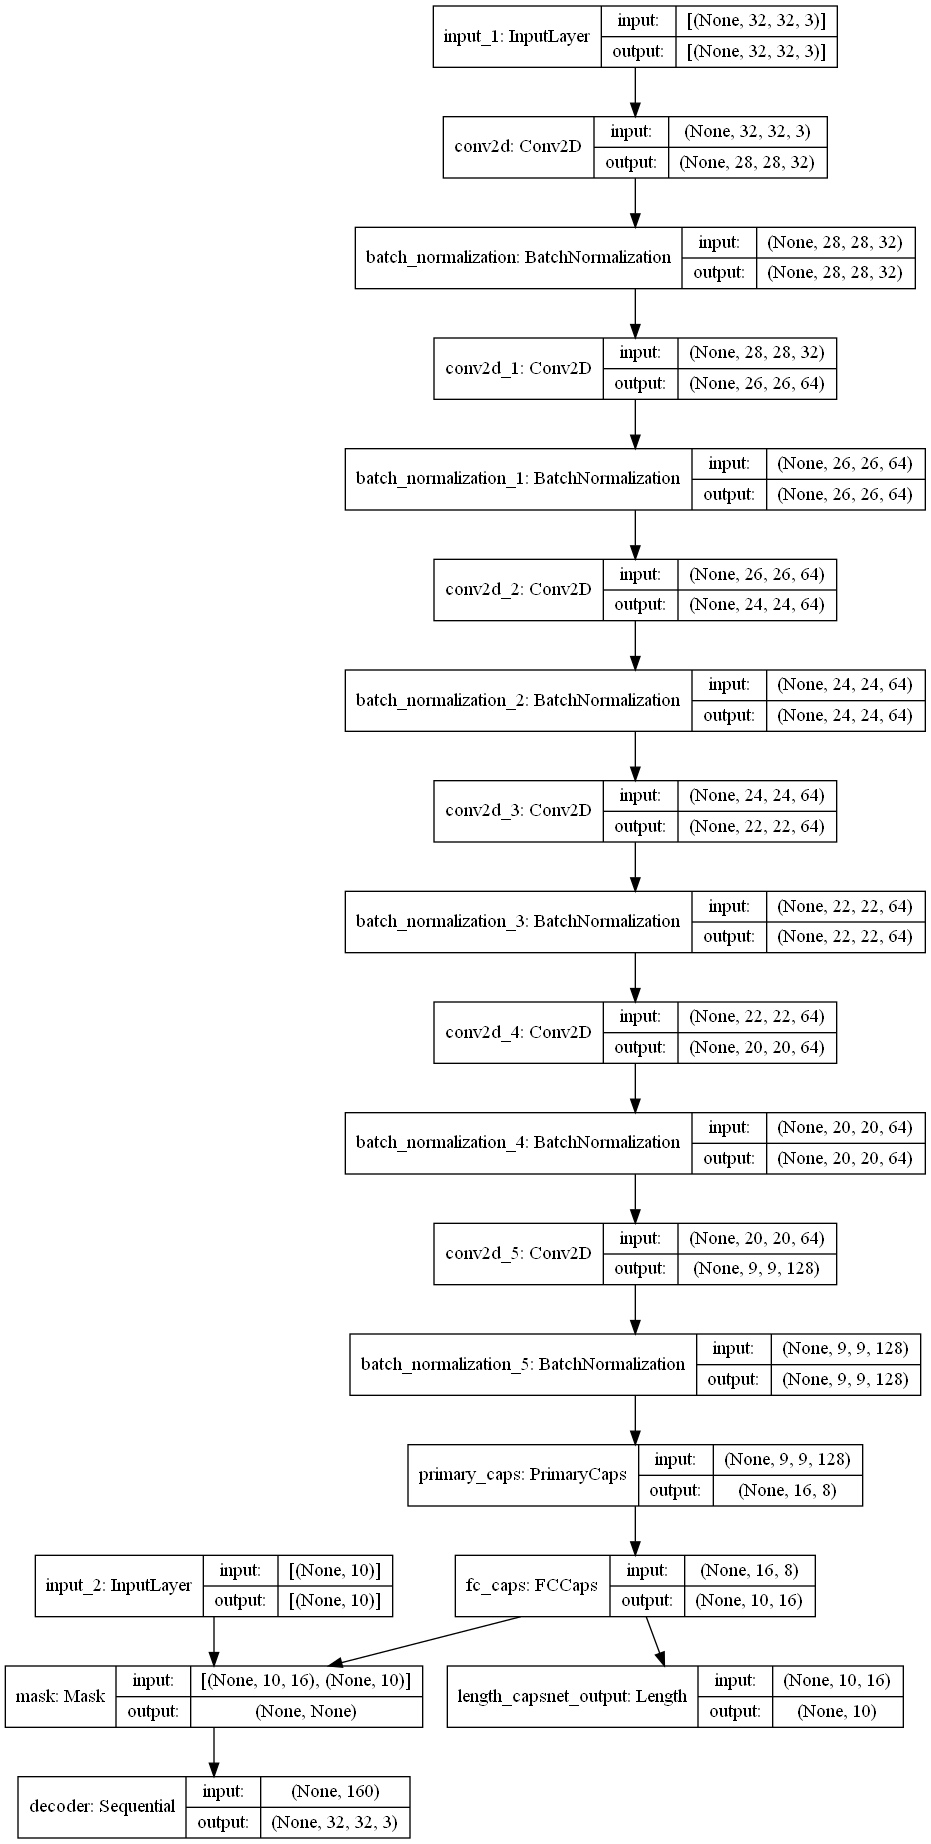

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    mean = tf.reduce_mean(tf.reduce_sum(L, 1))
    return mean


lr = 0.001
lam_recon = 0.392
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss=[margin_loss, 'mse', 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'length_capsnet_output': 'accuracy', 'decoder': 'accuracy'})
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

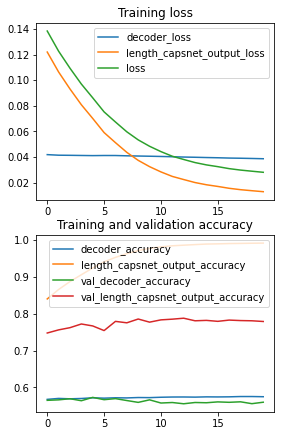

In [15]:
from utils.utils import combine_images, plot_log
from metrics import get_callbacks
run_fit = False
save_dir = './result/capsnet_cifar/capsnet_cifar_efficient-test1'
weights = save_dir + '/trained_model.h5'


def train_generator(x, y, batch_size, shift_fraction=0.):
    train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                       height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    for next_generated in generator:
        yield (next_generated[0], next_generated[1]), (next_generated[1], next_generated[0])


net_callbacks = get_callbacks(save_dir, lr, monitor='val_length_capsnet_output_accuracy')
if(run_fit):
    model.fit(train_generator(x_train, y_train, BATCH_SIZE),
              steps_per_epoch=int(y_train.shape[0] / BATCH_SIZE),
              epochs=20,
              validation_data=((x_test, y_test), (y_test, x_test)),
              batch_size=BATCH_SIZE,
              callbacks=[net_callbacks])
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)
else:
    model.load_weights(weights)

plot_log(save_dir + '/log.csv', show=True)


100
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_efficient-test1/images_eval.png
------------------------------End: test------------------------------


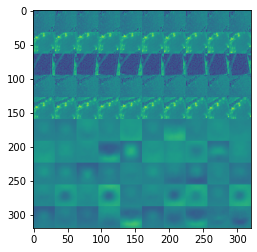

10000
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_efficient-test1/x_test.png
------------------------------End: test------------------------------


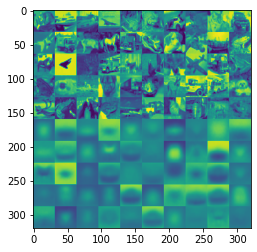

In [14]:
from images import get_images_eval
from PIL import Image
import matplotlib.pyplot as plt


def predict_and_print(save_dir, eval_model, x_test, file_name):
    x_recon = eval_model.predict(x_test, batch_size=100)
    print(len(x_recon[1]))
    # print('-' * 30 + 'Begin: test' + '-' * 30)
    img = combine_images(np.concatenate([x_test[:50], x_recon[1][:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(
        save_dir + "/" + file_name + ".png")
    print('Reconstructed images are saved to %s/%s.png' %
          (save_dir, file_name))
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(save_dir + "/" + file_name + ".png"))
    plt.show()


images_eval = get_images_eval()

predict_and_print(save_dir, eval_model, images_eval, "images_eval")
predict_and_print(save_dir, eval_model, x_test, "x_test")
